Subdivide the images of Covid + pneumonia into:
Train - validation - test sets.

Train PCA on the train set (keep 90% of info), generate component images.

Script of June 26th - July 3rd

See: module "dim reduction", intro lesson 1.

June 27th:load the images using OpenCV.

V4: appeler le chargement des images depuis une fonction.

_Résultat_: dans ce script, la fonction génère le DataFrame avec un ordre de lignes différent,
cela ne change pas le dessin, mais change le train-test split. Le score de la prédiction baisse de 0.87 à 0.68 (plus haut, que la random, amais en-dessous de la prédiction constante de la classe majoritaire == 0.74)!

Les performaces du modèle SVM varient entre 0.87, 0.68, 0.81 suite à des modifications aléatoires.

V5: charger les images par une  fonction spécifique.
_Résultat:_ le temps pour charger les images passe à 10 secondes.

PCA2_SVM : appliquer la séparation en 3 classes. Le score et les F1 sont de l'ordre de 0.67 à partir de 10000 époques.
Ce scode est identique à celui de CNN. On remarque cependant que la classe 1 (malade non-COVID) est relativement mieux séparée, alors que les deux autres se mélangent plus souvent.

PCA2_SVM_v2_fails: en cherchant la raison, j'ai affiché 2 pixels des données 'train' et 'val' de deux manières  différentes (matplotlib et seaborn). Les résultats ont un sens pour train, mais sont incompatibles pour les données 'val'! Aucun post sur les forums n'indique une raison possible de cette différence (j'en cherche une dans les données).

split_PCA2_SVM_v3_fails: Pour isoler le problème, simplifier le code: appeler les fonctions depuis des fichiers. Mais:
* ajouté les graphiques avant train-val-test split;
* comme les graphoiques sont corrects, décomposer la fonction train-val-test split en 2 parties avec des graphiques
 au milieu.

_Result_: a reasonable result has been obtained at the end! But it required calling X_val.index, which is lost in the results of PCA.

split_PCA2_SVM_2components : copy the indices to the new plotting function plot_df_scatter_dims12.plt_scatter_dims12  and the classifier. Train on 2 components (the ones, which are plotted). _Result_: score and mean F1 = 0.56 . One can detect that the class zero (healthy) is the hardest to classify. Not so bad for a baseline.


In [1]:
# imports
import os

import seaborn as sns
import time
import pandas as pd


from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import classification_report

from train_val_test_split import train_val_test_split
from load_images_PCA1_v5 import unfold_except_1st_dim

# imports for loading and visualizing data
from load_images_limit_TOCHECK import list_img, load_data
from plot_df_scatter_dims12 import plt_scatter_dims12
from plot_scatter_subplots import subplots_levels

image_path = '../data'

# Load data into a large tensor. 

Concatenate DataFrames using a single function call.
->

Reduce data to size 28*28, load to a tensor, NImages x 28 x 28,

In [2]:
# Hyperparamètres (réduction de l'image)
IMG_HEIGHT = 28
IMG_WIDTH = 28

# L'architecture du CNN peut aussi être déplacée ici.

In [3]:
def cond2folder(condition):
    return os.path.join(image_path, condition, "images")

Charger les images: 2500 COVID, (1250 Pneumo + 1250 Opacity), 2500 normaux choisies aléatoirement 

In [4]:
lst_conditions = ['COVID', 'Viral Pneumonia', 'Lung_Opacity', 'Normal']
lst_dirs = list(map(cond2folder, lst_conditions))
print(lst_dirs)

lst_labels = [2, 1, 1, 0]

print("labels:", lst_labels)

# determine the number of images to load
# num_COVID_img = len(list_img(lst_dirs[0]))
lst_nums_images = list(map(lambda path_dir: len(list_img(path_dir)), lst_dirs ))
print("Total number of images for each condition:", lst_nums_images)
# [3616, 6012, 1345]


['../data/COVID/images', '../data/Viral Pneumonia/images', '../data/Lung_Opacity/images', '../data/Normal/images']
labels: [2, 1, 1, 0]
Total number of images for each condition: [3616, 1345, 6012, 10192]


In [5]:
# Number of images to extract:
num_img_COV = 2500

balanced_lst_nums_images = [num_img_COV, num_img_COV//2, num_img_COV//2, num_img_COV]

print(balanced_lst_nums_images)
# [2500, 1250, 1250, 2500]


[2500, 1250, 1250, 2500]


Extract images.

In [6]:
start = time.time()
data, labels = load_data(lst_dirs,
                        lst_labels,
                        new_size=(IMG_WIDTH, IMG_HEIGHT),
                        limits=balanced_lst_nums_images,
                        random_state=42)
done = time.time()

elapsed = done - start
print(f'Loading data : {elapsed:.2f} sec \n\n')
# 7 sec

print(type(data))  # ndarray
print(data.shape)  # (7232, 28, 28, 1)

print(type(labels))  # ndarray
print(labels.shape)  # (7232,)

Loading data : 7.00 sec 


<class 'numpy.ndarray'>
(7500, 28, 28, 1)
<class 'numpy.ndarray'>
(7500,)


# Loading data from tensor to DF

In [7]:
data_mat = unfold_except_1st_dim(data)
var_target = 'group'

df = pd.DataFrame(data=data_mat)
df[var_target] = labels

print(df.shape)   # (7500, 785 == 28*28 + 1) 
print(df.info())

df.head()

(7500, 785)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Columns: 785 entries, 0 to group
dtypes: float64(784), int64(1)
memory usage: 44.9 MB
None


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,group
0,0.443137,0.443137,0.494118,0.486275,0.450980,0.478431,0.513725,0.549020,0.549020,0.509804,...,0.603922,0.584314,0.560784,0.545098,0.525490,0.505882,0.462745,0.376471,0.227451,2
1,0.105882,0.109804,0.109804,0.109804,0.109804,0.109804,0.101961,0.133333,0.137255,0.137255,...,0.749020,0.717647,0.635294,0.113725,0.152941,0.192157,0.160784,0.172549,0.188235,2
2,0.231373,0.168627,0.070588,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.980392,0.968627,0.941176,0.890196,0.831373,0.737255,0.611765,0.443137,0.058824,2
3,0.011765,0.011765,0.007843,0.007843,0.003922,0.039216,0.066667,0.086275,0.125490,0.145098,...,0.960784,0.949020,0.941176,0.933333,0.917647,0.894118,0.854902,0.847059,0.745098,2
4,0.258824,0.211765,0.211765,0.282353,0.349020,0.384314,0.400000,0.403922,0.392157,0.431373,...,0.843137,0.831373,0.811765,0.788235,0.764706,0.749020,0.635294,0.501961,0.384314,2


# train-validation-test split

In [8]:
# separate features, target.
data = df.drop(var_target, axis=1)
target = df[var_target]

print(data.info())  # (7500, 784)
print('------')
print(type(target))  # Series
print(target.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Columns: 784 entries, 0 to 783
dtypes: float64(784)
memory usage: 44.9 MB
None
------
<class 'pandas.core.series.Series'>
(7500,)


joint scatterplot with different shapes and colors

The shape of the plotted data: (7500, 784)
The shape of the classes: (7500,)
The color column is called: group
The number of points for each class:
group
2    2500
1    2500
0    2500
Name: count, dtype: int64


<Axes: xlabel='0', ylabel='1'>

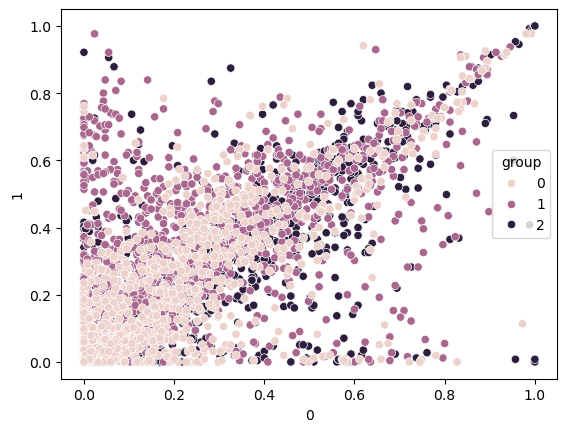

In [9]:
plt_scatter_dims12(data, target)

(<Figure size 500x1600 with 3 Axes>,
 array([<Axes: title={'center': 'Level: 2'}>,
        <Axes: title={'center': 'Level: 1'}>,
        <Axes: title={'center': 'Level: 0'}>], dtype=object))

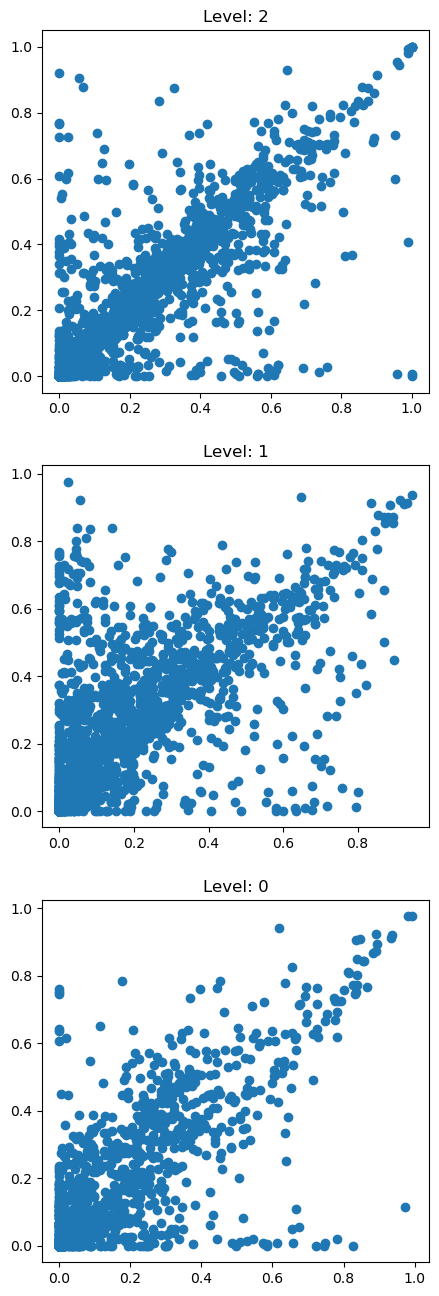

In [10]:
subplots_levels(data, target)
# This works, showing slightly different plots for each level

In [11]:

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data,
                                                                    target,
                                                                    random_state=42)

# -> (replaced for debugging by looking inside the temporary data)
"""
random_state=42

X_train_val, X_test, y_train_val, y_test = train_test_split(
        data,
        target,
        test_size=0.1,
        random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,
        y_train_val,
        test_size=0.2,
        random_state=random_state)
"""
print(X_train.shape)   # (5400, 784)
print(X_val.shape)     # (1350, 784)
print(X_test.shape)    # (750, 784)

print(y_train.shape)   # (5400,)
print(y_val.shape)     # (1350,)
print(y_test.shape)    # (750,)

(5400, 784)
(1350, 784)
(750, 784)
(5400,)
(1350,)
(750,)


In [12]:
print(X_train.index.equals(y_train.index))
print(X_val.index.equals(y_val.index))

True
True


The shape of the plotted data: (5400, 784)
The shape of the classes: (5400,)
The color column is called: group
The number of points for each class:
group
1    1823
0    1800
2    1777
Name: count, dtype: int64


<Axes: xlabel='0', ylabel='1'>

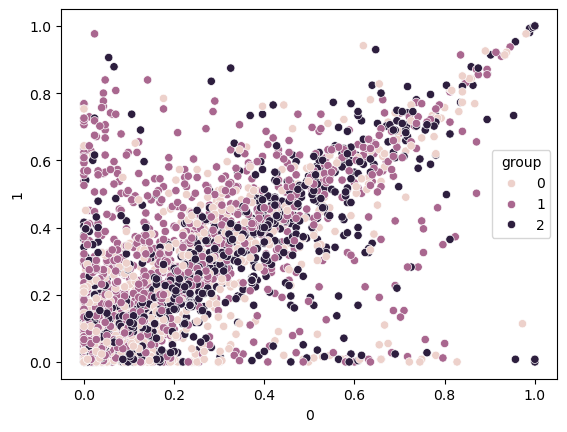

In [13]:
plt_scatter_dims12(X_train, y_train)

Scatterplots for debugging.

In [14]:
# subplots_levels(X_train, y_train)
# This works, showing slightly different plots for each level

Plotting the intermediate data (for debugging)

In [15]:
# plt_scatter_dims12(X_train_val.to_numpy(), y_train_val)

Scatterplots for debugging.

In [16]:
# subplots_levels(X_train_val, y_train_val)
# This works, showing slightly different plots for each level

In [17]:
# decomposed the previous function call,
# plt_scatter_dims12(X_val.to_numpy(), y_val) #->
data = X_val.to_numpy()
colors = y_val

print("The shape of the plotted data:", data.shape)
print("The shape of the classes:", colors.shape)
print("The color column is called:", colors.name)
    
# data_2cols = data[:, :2]
# df_2cols = pd.DataFrame(data=data_2cols, columns=['PCA1', 'PCA2'])
# df_2cols = pd.concat((df_2cols, colors), axis=1)

# print(df_2cols.info())
# df_2cols.head()
# why are there 2 NaNs  while all 13350 rows are "non-null" ?!

The shape of the plotted data: (1350, 784)
The shape of the classes: (1350,)
The color column is called: group


In [18]:
# print(df_2cols.iloc[1, 2])

In [19]:
# print(df_2cols.shape)  # (2445, 3)
# print(df_2cols.isna().sum(axis=0))
# each column is composed of 1095 Nulls and 1350 actual values)

In [20]:
# create the DF using merge instead of concat:
data_2cols = data[:, :2]
df_2cols = pd.DataFrame(data=data_2cols,
                        columns=['PCA1', 'PCA2'],
                        index=X_val.index)
# Without the parameter 'index', this would mix up indices!


The shape of the plotted data: (1350, 2)
The shape of the classes: (1350,)
The color column is called: group
The number of points for each class:
group
0    462
2    454
1    434
Name: count, dtype: int64


<Axes: xlabel='PCA1', ylabel='PCA2'>

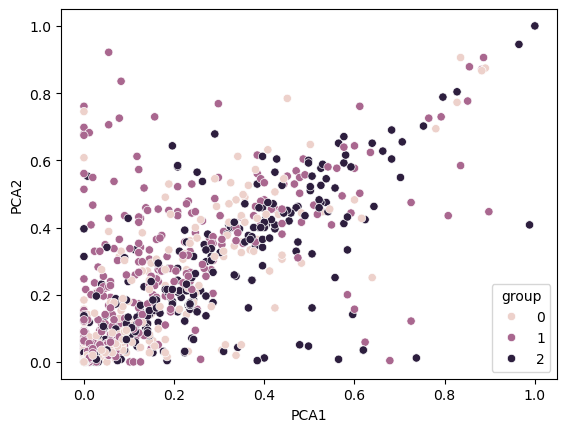

In [21]:
plt_scatter_dims12(df_2cols, y_val)

Matplotlib plot (reasonable)

(<Figure size 500x1600 with 3 Axes>,
 array([<Axes: title={'center': 'Level: 0'}>,
        <Axes: title={'center': 'Level: 2'}>,
        <Axes: title={'center': 'Level: 1'}>], dtype=object))

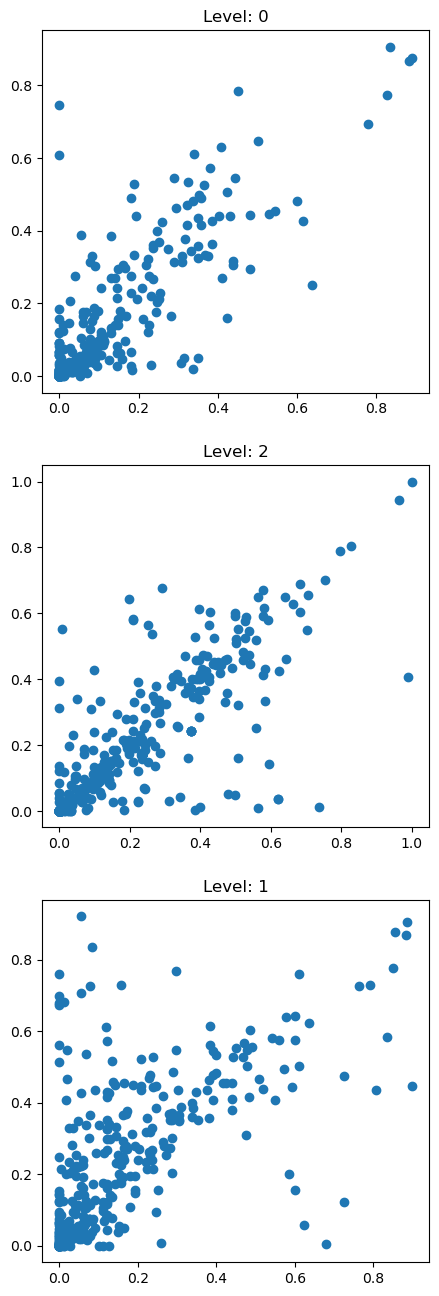

In [22]:
subplots_levels(X_val, y_val)
# This works showing slightly different plots for each level

# train PCA on train set
Output: number of components for achieving 90% of info.

In [23]:
# (p)
pca90 = PCA(n_components=0.9)

start = time.time()
X_train_pca = pca90.fit_transform(X_train)
done = time.time()

elapsed = done - start
print(f'Time for training PCA = {elapsed:.2f} sec \n\n')
# < 1sec

print(X_train_pca.shape)  # (5400, 47)

X_val_pca = pca90.transform(X_val)
print(X_val_pca.shape)  # (1350, 47)



Time for training PCA = 0.46 sec 


(5400, 47)
(1350, 47)


PCA a réduit le nombre de colonnes de près de 90000 à 50.

In [24]:
print(type(X_train_pca))
print(type(X_val_pca))  # ndarrays!

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# scatterplot of components 1, 2 colored according to their class

In [25]:
# def plt_scatter_dims12(data, colors):
"""
    Affiche les 2 premiéres colonnes d'une matrice.

    Args:
        data (_type_): _description_
        colors (_type_): _description_

    Returns:
        _type_: _description_
    """
    # return plt.scatter(data[:, 0], data[:, 1], c=colors)

"\n    Affiche les 2 premiéres colonnes d'une matrice.\n\n    Args:\n        data (_type_): _description_\n        colors (_type_): _description_\n\n    Returns:\n        _type_: _description_\n    "

The shape of the plotted data: (5400, 2)
The shape of the classes: (5400,)
The color column is called: group
The number of points for each class:
group
1    1823
0    1800
2    1777
Name: count, dtype: int64


<Axes: xlabel='PCA1', ylabel='PCA2'>

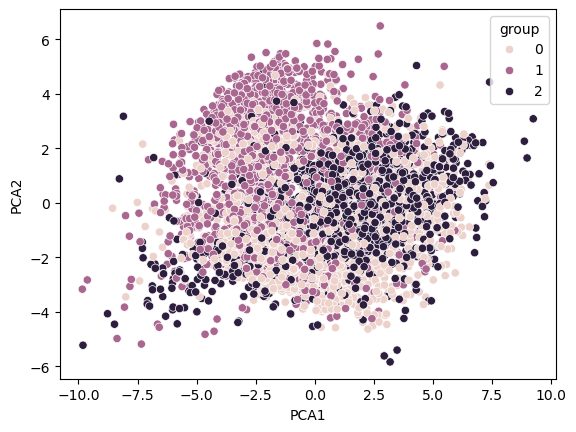

In [26]:
df_X_train_pca = pd.DataFrame(data=X_train_pca[:, :2],
                        columns=['PCA1', 'PCA2'],
                        index=X_train.index)

plt_scatter_dims12(df_X_train_pca, y_train)

In [27]:
print(type(y_val))
print(y_val.value_counts())

<class 'pandas.core.series.Series'>
group
0    462
2    454
1    434
Name: count, dtype: int64


The shape of the plotted data: (1350, 2)
The shape of the classes: (1350,)
The color column is called: group
The number of points for each class:
group
0    462
2    454
1    434
Name: count, dtype: int64


<Axes: xlabel='PCA1', ylabel='PCA2'>

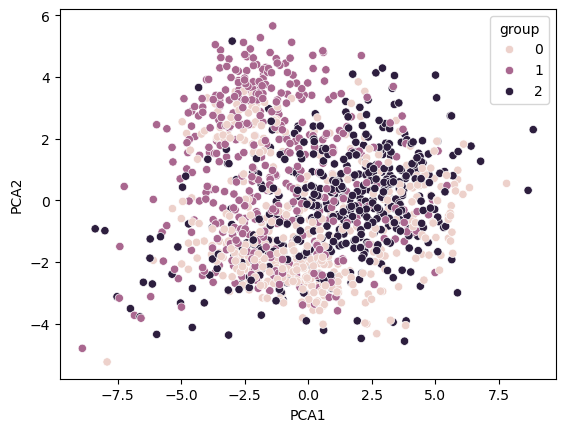

In [28]:
df_X_val_pca = pd.DataFrame(data=X_val_pca[:, :2],
                        columns=['PCA1', 'PCA2'],
                        index=X_val.index)

plt_scatter_dims12(df_X_val_pca, y_val)

Avec 2 variables, nous n'arrivons pas vraiment à séparer les 3 classes!

2 affichages suivants peuvent être ajoutés: Cercle de corrélations, eigenfaces.

Entrainer un classifieur sur le train, appliquer aux données de validation.



In [29]:
clf = SVC(C=1, kernel='linear', max_iter=50000, random_state=1)

start = time.time()
clf.fit(df_X_train_pca, y_train)
done = time.time()

elapsed = done - start
print(f'Training time on reduced data = {elapsed:.2f} sec \n\n')

print("Score on reduced data :", clf.score(df_X_val_pca, y_val))  # 0.556


Training time on reduced data = 0.86 sec 


Score on reduced data : 0.5562962962962963


/home/alex/anaconda3/envs/DSTest_proj_env06/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [30]:
y_pred_val = clf.predict(df_X_val_pca)
print(classification_report(y_val, y_pred_val))
# F1-scores : 0.51, 0.59, 0.57

              precision    recall  f1-score   support

           0       0.49      0.53      0.51       462
           1       0.60      0.58      0.59       434
           2       0.59      0.56      0.57       454

    accuracy                           0.56      1350
   macro avg       0.56      0.56      0.56      1350
weighted avg       0.56      0.56      0.56      1350



In [31]:
# confusion matrix
pd.crosstab(y_val, y_pred_val)

col_0,0,1,2
group,,,
0,246,103,113
1,120,252,62
2,135,66,253


The results are not very high, but much better than random guessing. The class zero (healthy) is the hardest to separate.